# 05. Model Explainability (SHAP)

## Mục tiêu
- Giải thích mô hình dự đoán Probability of Default (PD)
- Hiểu các yếu tố ảnh hưởng đến rủi ro tín dụng SMEs
- Đảm bảo mô hình minh bạch và có thể bảo vệ trước hội đồng

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PROJECT_ROOT = "/content/drive/MyDrive/NCKH"
DATA_PROCESSED = f"{PROJECT_ROOT}/data/processed"
MODELS_DIR = f"{PROJECT_ROOT}/models"
SRC_DIR = f"{PROJECT_ROOT}/src"

import sys
sys.path.insert(0, SRC_DIR)

print("Environment ready")

Environment ready


## Load dữ liệu đã được scoring và mô hình đã calibration

Giải thích được thực hiện trên:
- Mô hình PD đã calibration
- Dữ liệu test (out-of-sample)

In [3]:
import pandas as pd
import numpy as np
import os
from joblib import load

from config import FEATURE_COLUMNS
from scoring import calibrate_model
from features import add_features

# Load scored test data
df_scored = pd.read_csv(f"{DATA_PROCESSED}/scored_test_data.csv")

df_scored.shape

(225, 43)

## Load mô hình gốc (Base model)

SHAP giải thích **cấu trúc mô hình gốc**,  
không áp dụng trực tiếp trên bước calibration.

In [4]:
ARTIFACT_DIR = f"{MODELS_DIR}/artifacts"
model_file = [f for f in os.listdir(ARTIFACT_DIR) if f.endswith(".joblib")][0]
base_model = load(f"{ARTIFACT_DIR}/{model_file}")

model_file

'LightGBM.joblib'

## Chuẩn bị dữ liệu cho SHAP

Chỉ sử dụng:
- FEATURE_COLUMNS
- Không dùng biến nhãn, PD hay credit_score

In [5]:
X_shap = df_scored[FEATURE_COLUMNS]

X_shap.shape

(225, 18)

## Khởi tạo SHAP Explainer

- TreeExplainer: cho LightGBM / Random Forest
- KernelExplainer: cho Logistic Regression / SVM

In [14]:
from sklearn.pipeline import Pipeline
import shap

if isinstance(base_model, Pipeline):
    tree_model = base_model.steps[-1][1]   # lấy LGBMClassifier
else:
    tree_model = base_model

explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_shap)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## Global Explainability – Feature Importance

Biểu đồ này cho thấy:
- Biến nào ảnh hưởng nhiều nhất đến PD
- Ảnh hưởng theo cả chiều tăng/giảm

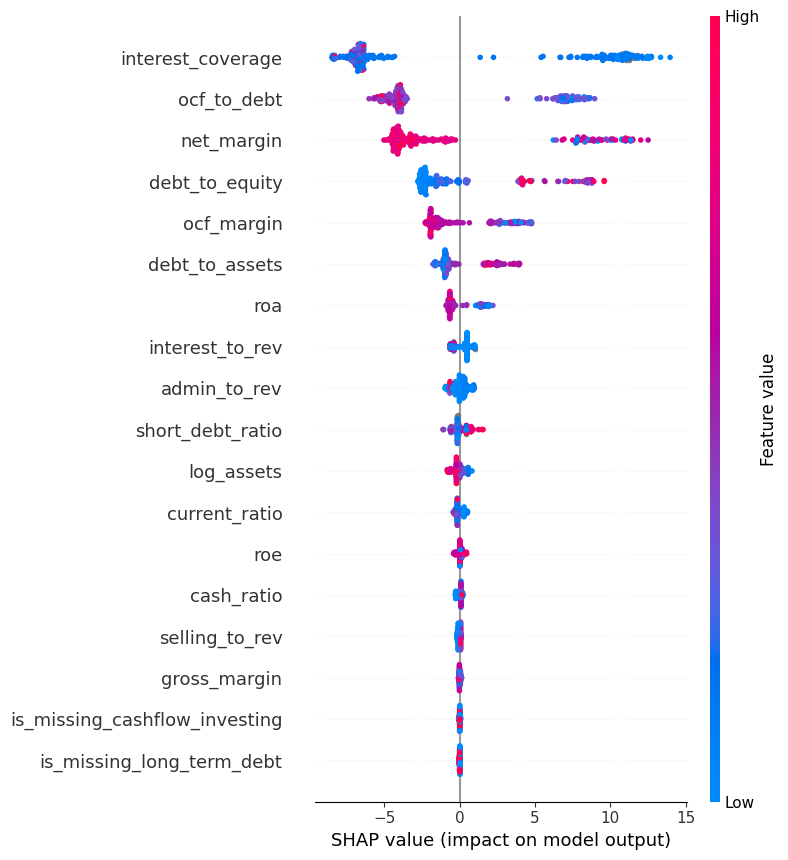

In [15]:
shap.summary_plot(
    shap_values[1] if isinstance(shap_values, list) else shap_values,
    X_shap,
    plot_type="dot",
    show=True
)

## Mean Absolute SHAP Value

Định lượng mức độ ảnh hưởng trung bình của từng biến.

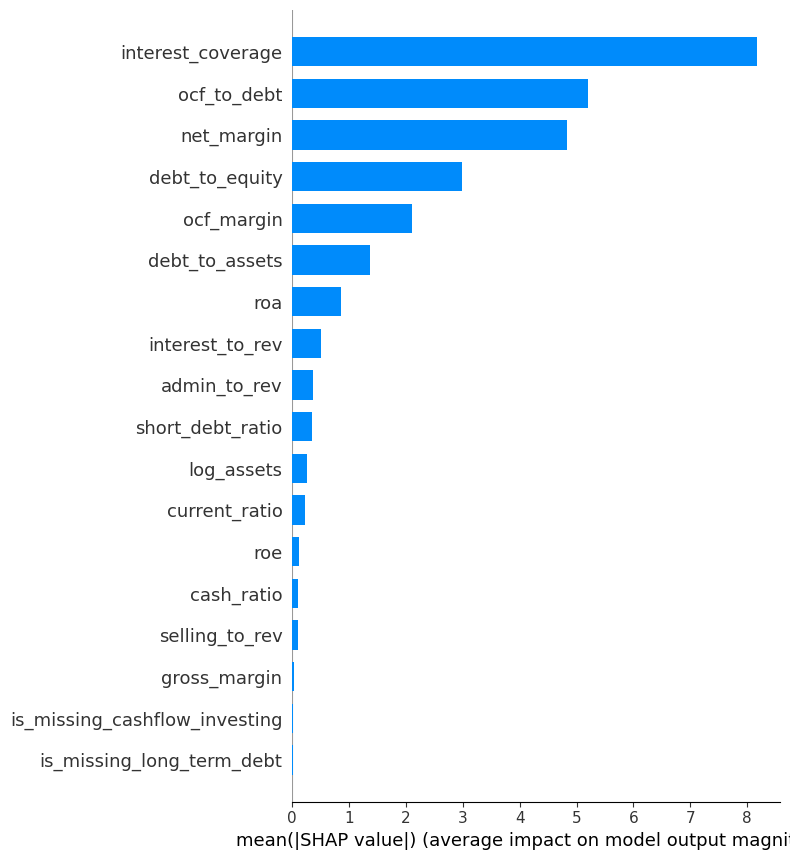

In [16]:
shap.summary_plot(
    shap_values[1] if isinstance(shap_values, list) else shap_values,
    X_shap,
    plot_type="bar",
    show=True
)

## Local Explainability – Giải thích từng doanh nghiệp

Ví dụ:
- Một SME có PD cao
- Phân tích vì sao mô hình đánh giá rủi ro cao

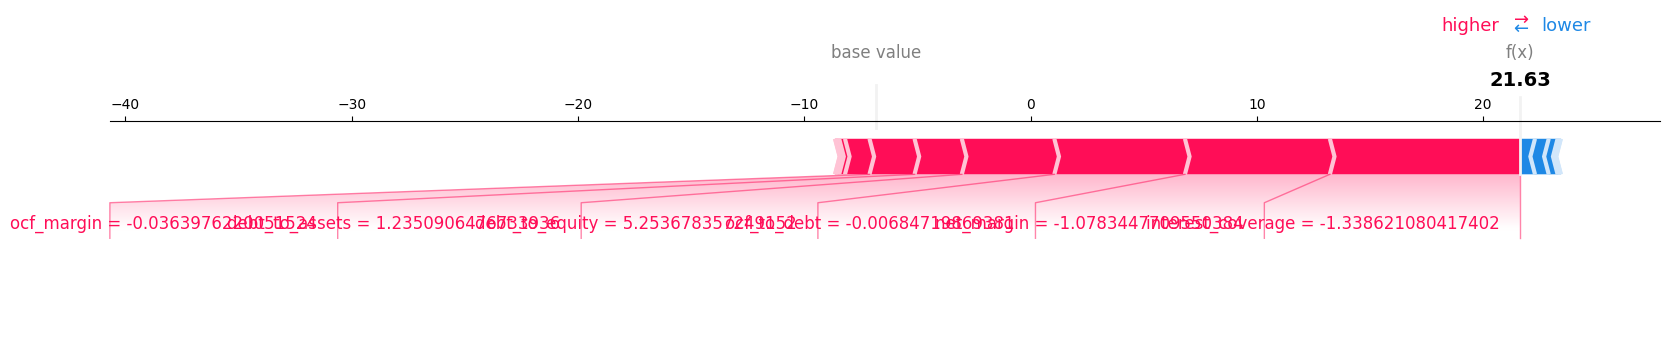

In [17]:
# Chọn 1 quan sát PD cao
idx = df_scored["PD"].sort_values(ascending=False).index[0]

shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list)
    else explainer.expected_value,
    shap_values[1][idx] if isinstance(shap_values, list) else shap_values[idx],
    X_shap.loc[idx],
    matplotlib=True
)

## Thảo luận kết quả Explainability

Các yếu tố thường ảnh hưởng mạnh:
- Đòn bẩy tài chính (debt ratios)
- Khả năng sinh lời (ROA, ROE)
- Dòng tiền hoạt động
- Quy mô doanh nghiệp

Kết quả phù hợp với lý thuyết tài chính và thực tiễn tín dụng.

## Tổng kết Notebook 05

Notebook này đã:
- Giải thích mô hình PD bằng SHAP
- Phân tích ảnh hưởng toàn cục và cục bộ
- Đảm bảo tính minh bạch của mô hình

Đây là bước quan trọng để mô hình có thể ứng dụng thực tế.